# Lab 3- Decision Trees

This assignment uses a dataset obtained from the JSE Data Archive that aims at identifying whether there is a statistically significant dependence between gender and biological/activity traits in humans. 

FEATURE DESCRIPTIONS: 

<ul>
<li>Color (Blue, Brown, Green, Hazel, Other)
<li>Age (in years)
<li>YearinSchool (First, Second, Third, Fourth, Other)
<li>Height (in inches)
<li>Miles (distance from home town of student to Ames, IA) 
<li>Brothers (number of brothers)
<li>Sisters (number of sisters)
<li>CompTime (number of hours spent on computer per week)
<li>Exercise (whether the student exercises Yes or No)
<li>ExerTime (number of hours spent exercising per week)
<li>MusicCDs (number of music CDs student owns)
<li>PlayGames (number of hours spent playing games per week)
<li>WatchTV (number of hours spent watching TV per week
</ul>

https://ww2.amstat.org/publications/jse/jse_data_archive.htm

In [1]:
from __future__ import division
from collections import Counter, defaultdict
from itertools import combinations 
import pandas as pd
import numpy as np
import operator
import math
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer #to turn categorial variables into numeric arrays
from sklearn import preprocessing #to transform the feature labels

In [2]:
df = pd.read_csv('Eye_Color.csv')

df.head()

,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


In [3]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

# Calculating Gini Index 



**Question 1: How many rows are there in the dataset for males? For females? **



In [4]:
len(df[df["gender"] == "male"])

910

In [5]:
len(df[df["gender"] == "female"])

1078

**Question 2: What is the Gini Index of this dataset, using males and females as the target classes?**

##### Formula Used: Gini(D) = 1 - sum(frac**2 for frac in classes) i.e Sum of the squares of the fraction of items in each class

In [6]:
1 - ((math.pow(len(df[df["gender"] == "male"])/len(df),2) + math.pow(len(df[df["gender"] == "female"])/len(df),2)))

0.4964292799047807

Gini index using males and females as target classes is 0.4964292799047807

## Best Split of a Numeric Feature

**Question 3: What is the best split point of the 'height' feature. **

In [7]:
df.sort("height", inplace=True)
df = df.reset_index(drop=True)

/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [8]:
best_gini_idx = 1
best_ht_split = 0
heights_list = list(set(df["height"]))
for i in range(1, len(heights_list)):
    height1 = heights_list[i-1]
    height2 = heights_list[i]
    split_point_height = (height1 + height2)/2
    left_split_df = df[df["height"] <= split_point_height]
    right_split_df = df[df["height"] > split_point_height]
    left_gini_idx = 1 - ((math.pow(len(left_split_df[left_split_df["gender"] == "male"])/len(left_split_df),2) + math.pow(len(left_split_df[left_split_df["gender"] == "female"])/len(left_split_df),2)))
    right_gini_idx = 1 - ((math.pow(len(right_split_df[right_split_df["gender"] == "male"])/len(right_split_df),2) + math.pow(len(right_split_df[right_split_df["gender"] == "female"])/len(right_split_df),2)))
    avg_gini_idx = ((len(left_split_df)/len(df))*left_gini_idx) + ((len(right_split_df)/len(df))*right_gini_idx)
    if best_gini_idx > avg_gini_idx:
        best_gini_idx = avg_gini_idx
        best_ht_split = split_point_height
print(best_gini_idx, best_ht_split)
    

0.2655288120702919 68.5


Best split point for height is 68.5 inches

**Question 4: What is the Gini Index of this best split?**

Gini index of best split point is 0.2655288120702919

**Question 5: How much does this partitioning reduce the Gini Index over that of the overall dataset?**

In [9]:
0.4964292799047807 - 0.2655288120702919

0.2309004678344888

This partitioning reduces the Gini index by 0.2309004678344888

**Question 6: How many 'female' rows are below your best split point? 'male' rows?**

In [10]:
left_split_df = df[df["height"] <= 68.5]
print(len(left_split_df[left_split_df["gender"] == "female"]),len(left_split_df[left_split_df["gender"] == "male"]))

905 142


There are 905 females and 142 males below the best split point.

**Question 7: How many 'female' rows are above your best split point? 'male' rows?**

In [11]:
right_split_df = df[df["height"] > 68.5]
print(len(right_split_df[right_split_df["gender"] == "female"]),len(right_split_df[right_split_df["gender"] == "male"]))

173 768


There are 173 females and 768 males above the best split point.

Recall that, to calculate the best split of this numeric field, you'll need to order your data by 'height', then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to minimize the Gini Index). 

There are a lot of ways to do this. Some are very fast, others very slow. One tip to make this run quickly is, as you consecutively step through the data and calculate the Gini Index of each possible split point, keep a running total of the number of rows for each candidate that are located above and below the split point. 

Some Python tips: 

* Counter(), from the collections module, is a special dictionary for counting values of a key
* zip() lets you concatenate lists into a list of tuples (for example, if we have a list of the candidates and a list of transaction amounts, zip(candidate_list, transaction_amount) would give us a list of (candidate, transaction amount) pairs

## Best Split of a Categorial Variable

**Question 8: How many possible splits are there of the eyecolor feature?**

In [20]:
eye_color = set(df.eyecolor)
eye_color_sets = []
for set_length in range(1,len(eye_color)):
    eye_color_sets.extend([sets for sets in combinations(eye_color, set_length)])
len(eye_color_sets)/2


15.0

There are 15 possible splits of eyecolor feature

**Question 9: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?**

In [13]:
best_gini_idx = 1
best_eyecolor_split = []
for eye_color_set in eye_color_sets:
    left_split_df = df[df["eyecolor"].isin(eye_color_set)]
    right_split_df = df[~df["eyecolor"].isin(eye_color_set)]
    left_gini_idx = 1 - ((math.pow(len(left_split_df[left_split_df["gender"] == "male"])/len(left_split_df),2) + math.pow(len(left_split_df[left_split_df["gender"] == "female"])/len(left_split_df),2)))
    right_gini_idx = 1 - ((math.pow(len(right_split_df[right_split_df["gender"] == "male"])/len(right_split_df),2) + math.pow(len(right_split_df[right_split_df["gender"] == "female"])/len(right_split_df),2)))
    avg_gini_idx = ((len(left_split_df)/len(df))*left_gini_idx) + ((len(right_split_df)/len(df))*right_gini_idx)
    if best_gini_idx > avg_gini_idx:
        best_gini_idx = avg_gini_idx
        best_eyecolor_split = eye_color_set
print(best_gini_idx, best_eyecolor_split)

0.4930915729509777 ('green',)


**Question 10: What is the Gini Index of this best split?**

The gini index of the best split is 0.4930915729509777

**Question 11: How much does this partitioning reduce the Gini Index over that of the overall data set?**

In [14]:
0.4964292799047807 - 0.4930915729509777

0.003337706953802977

This partitioning reduces the Gini index by 0.003337706953802977

**Question 12: How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?**

In [15]:
left_split_df = df[df["eyecolor"].isin(best_eyecolor_split)]
right_split_df = df[~df["eyecolor"].isin(best_eyecolor_split)]
print(len(left_split_df[left_split_df["gender"] == "female"]),len(left_split_df[left_split_df["gender"] == "male"]))
print(len(right_split_df[right_split_df["gender"] == "female"]),len(right_split_df[right_split_df["gender"] == "male"]))

190 107
888 803


In the first partition, there are 190 females and 107 males.
In the second partition, there are 888 females and 803 males.

Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list

## Training a decision tree

**Question 13: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (including the root node and leaf nodes). What is the accuracy of this classifier on the training data?**

In [16]:
vec = DictVectorizer()
df_num = vec.fit_transform(df.iloc[:,1:].to_dict('records')).toarray()
le = preprocessing.LabelEncoder()
le.fit(["male","female"])
target = le.transform(df.gender)

In [17]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(df_num, target)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
dt.score(df_num, target)

0.84507042253521125

The accuracy of the classifier on the training data is 84.5%

**Question 14: Using the following code snippet, export your decision tree to graphviz and visualize it. In your write-up, write down the interpretation of the rule at each node which is used to perform the splitting.**

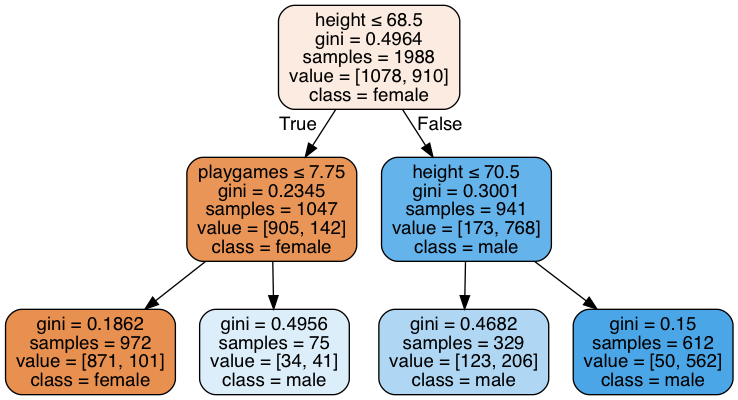

In [19]:
from IPython.display import Image  
import pydotplus 
dot_data = sklearn.tree.export_graphviz(dt, out_file=None,feature_names=vec.feature_names_,class_names=['female','male'],filled=True, rounded=True,special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf('name.pdf')
Image(graph.create_png())

At the root node, the split is on height <= 68.5.
At the 2nd level left node, the split is on playgames <= 7.75
At the 2nd level right node, the split is on height <= 70.5

**Question 15: For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node).**

(From left to right)
Leaf Node1: 871/972*100 = 89.6%
Leaf Node 2: 34/75*100 = 45.3%
Leaf Node 3: 123/329*100 = 37.4%
Leaf Node 4: 50/612*100 = 8.2%

See this notebook for the basics of training a decision tree in scikit-learn and exporting the outputs to view in graphviz: http://nbviewer.ipython.org/gist/tebarkley/b68c04d9b31e64ce6023

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: http://nbviewer.ipython.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().